# S&P 500 Price Prediction Using Machine Learning Techniques

## Sebastian Gonzalez

This script utilizes a dataset from the UCI Machine Learning Repository to predict S&P 500 prices using various machine learning models.

## Dataset source:

https://archive.ics.uci.edu/ml/datasets/CNNpred%3A+CNN-based+stock+market+prediction+using+a+diverse+set+of+variables

## Introduction

The objective of this project is to predict S&P 500 stock prices using a dataset containing various financial indicators.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor

## Load and preprocess the dataset

In [2]:
df = pd.read_csv("Processed_S&P.csv")
df.set_index('Date', inplace=True) # Setting 'Date' as the index for time series analysis

## Preliminary data inspection

In [3]:
df.head()

,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,ROC_20,...,NZD,silver-F,RUSSELL-F,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU
Date,,,,,,,,,,,,,,,,,,,,,
2009-12-31,1115.099976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.03,0.26,-1.08,-1.00,-0.11,-0.08,-0.06,-0.48,0.30,0.39
2010-01-04,1132.989990,0.921723,0.016043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.52,3.26,1.61,1.62,-0.57,-0.59,-0.42,3.12,3.91,2.10
2010-01-05,1136.520020,-0.375903,0.003116,0.016043,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.07,1.96,-0.20,0.31,0.43,0.03,0.12,-0.90,1.42,-0.12
2010-01-06,1137.140015,0.996234,0.000546,0.003116,0.016043,NaN,NaN,NaN,NaN,NaN,...,0.56,2.15,-0.02,0.07,-0.56,-0.24,-0.17,2.62,2.25,1.77
2010-01-07,1141.689941,0.059932,0.004001,0.000546,0.003116,0.016043,NaN,NaN,NaN,NaN,...,-0.72,0.94,0.50,0.40,0.58,0.58,0.54,-1.85,0.22,-0.58


In [4]:
df.describe()

,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,ROC_20,...,NZD,silver-F,RUSSELL-F,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU
count,1984.000000,1983.000000,1983.000000,1982.000000,1981.000000,1980.000000,1979.000000,1974.000000,1969.000000,1964.000000,...,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000,1982.000000,1984.000000,1984.000000
mean,1731.975468,0.018567,0.000464,0.000467,0.000468,0.000468,0.227627,0.449349,0.676329,0.910393,...,-0.001507,-0.047314,0.063634,0.043674,-0.002268,0.010726,0.010338,-0.014743,0.010418,0.010025
std,428.034426,0.211972,0.009335,0.009336,0.009338,0.009341,1.968650,2.567153,3.091296,3.473331,...,0.752757,1.944127,1.254398,0.942540,0.742651,0.483800,0.495002,1.935339,1.832492,1.027910
min,1022.580017,-0.761155,-0.066634,-0.066634,-0.066634,-0.066634,-13.013815,-16.297682,-15.467927,-16.467412,...,-4.120000,-17.750000,-7.540000,-7.220000,-15.760000,-2.390000,-4.280000,-11.060000,-12.930000,-8.490000
25%,1325.682464,-0.085050,-0.003340,-0.003335,-0.003340,-0.003340,-0.656504,-0.840703,-0.837394,-0.877628,...,-0.450000,-0.952500,-0.570000,-0.342500,-0.340000,-0.270000,-0.270000,-1.190000,-0.840000,-0.520000
50%,1791.075012,-0.001709,0.000544,0.000545,0.000545,0.000545,0.363267,0.627857,0.959036,1.307344,...,-0.010000,-0.030000,0.120000,0.060000,0.000000,0.010000,0.000000,-0.085000,0.030000,0.020000
75%,2081.265014,0.089874,0.004978,0.004985,0.004992,0.004992,1.327474,2.010766,2.548141,3.079939,...,0.470000,0.930000,0.740000,0.500000,0.350000,0.280000,0.280000,1.067500,0.920000,0.570000
max,2594.379883,3.234605,0.047407,0.047407,0.047407,0.047407,8.702459,9.245563,14.097137,14.016181,...,3.430000,12.810000,7.390000,5.440000,9.680000,2.180000,3.980000,12.310000,6.530000,4.800000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1984 entries, 2009-12-31 to 2017-11-15
Data columns (total 83 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           1984 non-null   float64
 1   Volume          1983 non-null   float64
 2   mom             1983 non-null   float64
 3   mom1            1982 non-null   float64
 4   mom2            1981 non-null   float64
 5   mom3            1980 non-null   float64
 6   ROC_5           1979 non-null   float64
 7   ROC_10          1974 non-null   float64
 8   ROC_15          1969 non-null   float64
 9   ROC_20          1964 non-null   float64
 10  EMA_10          1975 non-null   float64
 11  EMA_20          1965 non-null   float64
 12  EMA_50          1935 non-null   float64
 13  EMA_200         1785 non-null   float64
 14  DTB4WK          1984 non-null   float64
 15  DTB3            1984 non-null   float64
 16  DTB6            1984 non-null   float64
 17  DGS5            1984 no

In [6]:
nan_cols = df.columns[df.isnull().any()].tolist()
nan_cols

['Volume',
 'mom',
 'mom1',
 'mom2',
 'mom3',
 'ROC_5',
 'ROC_10',
 'ROC_15',
 'ROC_20',
 'EMA_10',
 'EMA_20',
 'EMA_50',
 'EMA_200',
 'Oil',
 'Gold',
 'GBP',
 'JPY',
 'CAD',
 'CNY',
 'AAPL',
 'AMZN',
 'GE',
 'JNJ',
 'JPM',
 'MSFT',
 'WFC',
 'XOM',
 'FCHI',
 'FTSE',
 'GDAXI',
 'DJI',
 'HSI',
 'IXIC',
 'SSEC',
 'RUT',
 'NYSE',
 'CTB3M',
 'CTB6M',
 'CTB1Y',
 'CAC-F',
 'DAX-F',
 'FTSE-F',
 'HSI-F',
 'KOSPI-F',
 'wheat-F']

## Data Cleaning
### Remove the first row as it is based on differences from previous periods

In [7]:
df.drop(index=df.index[0], inplace=True)

### Drop columns that are less likely to contribute to S&P 500 price prediction

In [8]:
columns_to_drop = ['Volume', 'mom', 'mom1', 'mom2', 'mom3', 'ROC_5', 'ROC_10', 'ROC_15', 'ROC_20', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_200', 'Name']
df.drop(columns=columns_to_drop, inplace=True)

### Impute missing values with column mean

In [9]:
df.fillna(df.mean(), inplace=True)

### Normalize column names by removing spaces and converting to upper case

In [10]:
df.columns = df.columns.str.replace(' ', '').str.upper()

## Exploratory Data Analysis (EDA)
### Assess the distribution and correlations within the data

In [11]:
df.describe()

,CLOSE,DTB4WK,DTB3,DTB6,DGS5,DGS10,OIL,GOLD,DAAA,DBAA,...,NZD,SILVER-F,RUSSELL-F,S&P-F,CHF,DOLLARINDEX-F,DOLLARINDEX,WHEAT-F,XAG,XAU
count,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,...,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000,1983.000000
mean,1732.286550,0.160721,0.190847,0.261296,1.453984,2.356475,-0.000453,-0.020158,4.097902,5.070368,...,-0.001523,-0.047468,0.064211,0.044201,-0.002214,0.010772,0.010373,-0.014508,0.010272,0.009834
std,427.918002,0.245166,0.272610,0.298789,0.484869,0.602793,0.030872,0.141000,0.636644,0.708246,...,0.752947,1.944605,1.254451,0.942486,0.742835,0.483917,0.495124,1.934823,1.832943,1.028134
min,1022.580017,-0.030000,-0.020000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,...,-4.120000,-17.750000,-7.540000,-7.220000,-15.760000,-2.390000,-4.280000,-11.060000,-12.930000,-8.490000
25%,1325.759949,0.020000,0.030000,0.080000,1.110000,1.940000,-0.011022,-0.005858,3.710000,4.660000,...,-0.450000,-0.955000,-0.570000,-0.340000,-0.340000,-0.270000,-0.270000,-1.190000,-0.840000,-0.520000
50%,1791.530029,0.060000,0.090000,0.140000,1.510000,2.270000,0.000274,0.000000,3.990000,5.050000,...,-0.010000,-0.030000,0.120000,0.060000,0.000000,0.010000,0.000000,-0.080000,0.030000,0.020000
75%,2081.290039,0.160000,0.175000,0.340000,1.760000,2.665000,0.010704,0.005460,4.470000,5.430000,...,0.470000,0.930000,0.740000,0.500000,0.350000,0.280000,0.280000,1.065000,0.920000,0.570000
max,2594.379883,1.280000,1.240000,1.370000,2.750000,4.010000,0.119511,0.049577,5.490000,6.510000,...,3.430000,12.810000,7.390000,5.440000,9.680000,2.180000,3.980000,12.310000,6.530000,4.800000


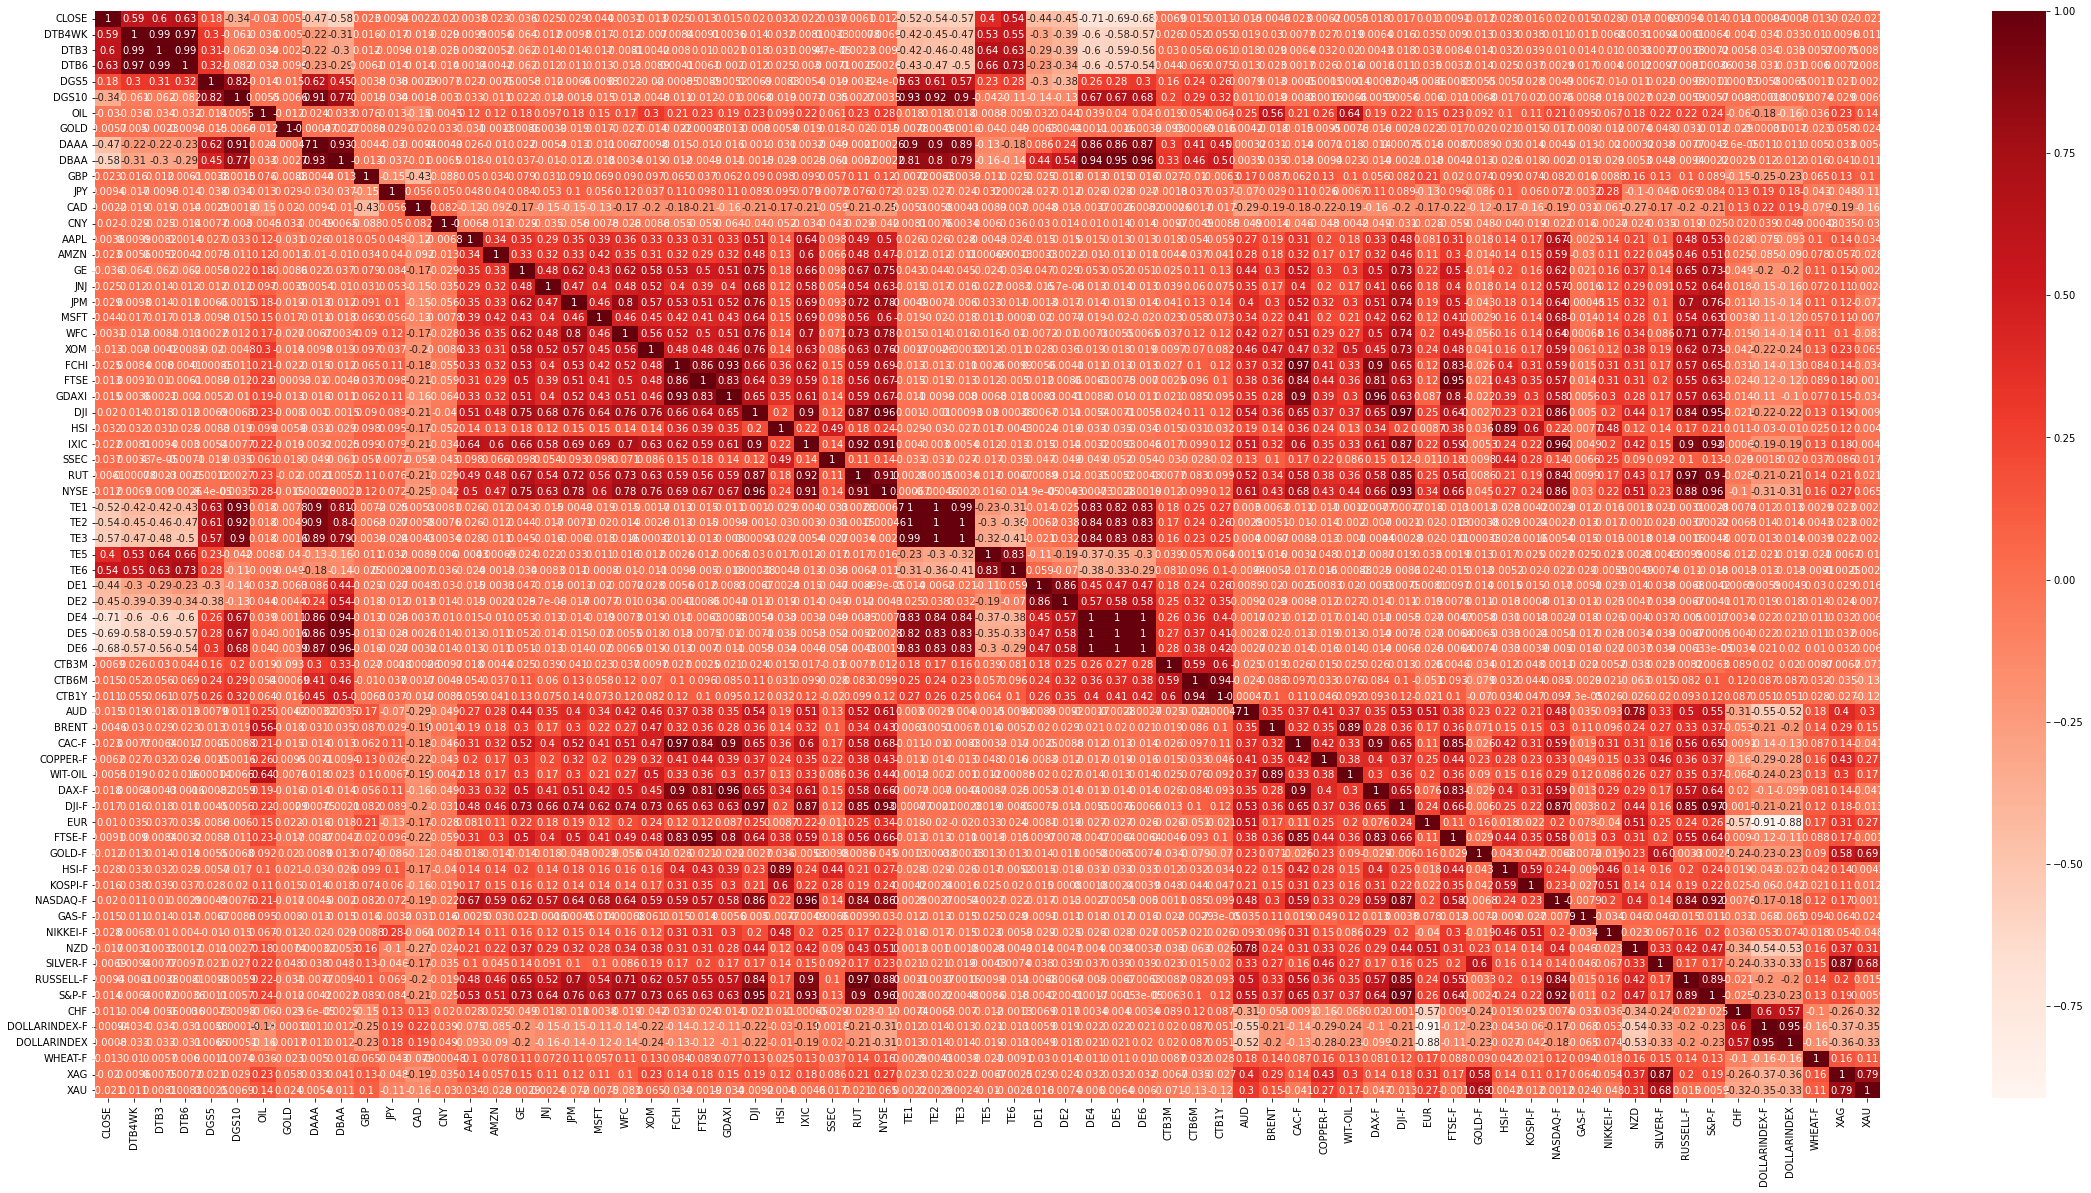

In [12]:
plt.figure(figsize=(40,20))
sns.heatmap(df.corr(), annot=True, cmap='Reds')
plt.show()

## Feature Engineering

### Select features with high correlation to 'CLOSE' price

In [13]:
high_corr_features = df.corr()['CLOSE'].abs().sort_values(ascending=False).head(20).index.tolist()

### Feature selection methods

In [14]:
selector_vt = VarianceThreshold(threshold=0.8)
selector_vt.fit(df[high_corr_features], df['CLOSE'])

VarianceThreshold(threshold=0.8)

In [15]:
selector_skb = SelectKBest(k=15)
selector_skb.fit(df.drop(columns=['CLOSE']), df['CLOSE'])

SelectKBest(k=15)

## Model Training and Evaluation

In [16]:
X = df.drop(columns=['CLOSE']) # Features for the model
y = df['CLOSE'] # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Function to create a simple ANN model

In [17]:
def create_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

### Function to create an LSTM model

In [18]:
def create_lstm_model(optimizer='adam'):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(1, X_train.shape[1])))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

## Initialize models

In [19]:
# Here we demonstrate initializing the Lasso model, which will be part of the pipeline
lasso_model = Lasso(max_iter=10000)
ann_model = KerasRegressor(build_fn=lambda: create_model(optimizer='adam'), verbose=0)
svr_model = SVR(kernel='rbf')
#lstm_model = KerasRegressor(build_fn=lambda: create_lstm_model(optimizer='adam'), verbose=0)

C:\Users\SebastianGM\AppData\Local\Temp\ipykernel_152892\4262463435.py:3: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ann_model = KerasRegressor(build_fn=lambda: create_model(optimizer='adam'), verbose=0)


In [20]:
#models = [lasso_model, ann_model, svr_model, lstm_model]
models = [lasso_model, ann_model, svr_model]
#model_names = ['Lasso Regression', 'Artificial Neural Network', 'Support Vector Regression', 'Long Short-Term Memory']
model_names = ['Lasso Regression', 'Artificial Neural Network', 'Support Vector Regression']

## Pipeline and Results

In [21]:
# The pipeline incorporates scaling and the prediction model for cleaner code and better reproducibility
results = []
for model, name in zip(models, model_names):
    pipeline = Pipeline([('scaler', RobustScaler()), ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    score_r2 = r2_score(y_test, y_pred)
    score_rmse = mean_squared_error(y_test, y_pred, squared=False)
    results.append((name, score_r2, score_rmse))

# Sort results by best performance

In [22]:
results_df = pd.DataFrame(results, columns=['Model', 'R2', 'RMSE']).sort_values(by=['R2', 'RMSE'], ascending=[False, True])

## Conclusion

After a comprehensive analysis and rigorous evaluation of different machine learning models on the S&P 500 dataset,
we have identified a standout performer that promises to offer insightful forecasts for the S&P 500 stock prices.

### Extract the top-performing model based on the R2 score and RMSE

In [23]:
best_model = results_df.iloc[0]

### Display the results of the best model

In [24]:
print(f"Best performing model: {best_model['Model']} with R2 score: {best_model['R2']:.4f} and RMSE: {best_model['RMSE']:.4f}")

Best performing model: Lasso Regression with R2 score: 0.8789 and RMSE: 149.1309


## Reflecting on the Model's Performance

The Lasso Regression model has emerged as the best model with an R2 score of 0.8789 and an RMSE of 149.1309.
This suggests a high level of accuracy in the model's predictions, with the R2 score indicating that a significant portion of the variance in the S&P 500 stock prices is being captured by the model's inputs.

### Implications for Future Predictions and Analysis

The robust performance of the Lasso Regression model provides a solid foundation for making future price predictions.
Investors and analysts can leverage this model to make informed decisions by understanding the potential movements in the stock market. It's also a valuable tool for further academic research and practical application in financial analysis.

### Next Steps

To further enhance the model's predictive power, future work may involve experimenting with additional feature engineering, hyperparameter tuning, and even ensembling methods that combine the strengths of various models.
Continuously updating the model with new data and refining its predictions are crucial steps to maintaining its relevance and accuracy in a dynamic market environment.

The pursuit of machine learning excellence in stock market prediction continues, and this project serves as a testament to the power of data-driven decision-making in the financial domain.